# Imports

In [1]:
import time
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import os, sys
import seaborn as sns
import json
import sqlite3

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, explained_variance_score, max_error, mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, CatBoostRegressor

In [2]:
ROOT_DATA_FOLDER = "../data"
API_DATE_FORMAT = "%Y-%m-%dT%H:%M:%SZ"
RANDOM_STATE = 40

# Functions

In [3]:
def pad(l: list, n: int, value=0):
    return l + [value] * (n - len(l))

In [4]:
def get_stat_columns(stat_name):
    """
    Get the columns of a stat from all players.
    :param feature_name: 
    :return: 
    """
    return [f"player_{i}_{stat_name}" for i in range(1, 13)]

In [5]:
def get_cols_name(player_range_start: int, player_range_end: int):
    """
    Get columns of all stats from the range of players
    :param player_range_start: 
    :param player_range_end: 
    :return: 
    """
    return np.array(
        [[f"player_{i}_{stat}" for stat in STATS_NAME] for i in range(player_range_start, player_range_end)]).reshape(
        (player_range_end - player_range_start) * N_STATS)

In [6]:
def get_player_columns(player_number):
    """
    Get all columns of a player.
    :param player_number: 
    :return: 
    """
    return [f"player_{player_number}_{stat}" for stat in STATS_NAME]

In [7]:
# Shuffle teams so that half of the activities were won
def shuffle_winning_team(df):
    # Not optimal - renaming columns but the rvalue consume memory as well
    mid = len(df) // 2

    # First shuffle dataframe to ensure dates are shuffle as well
    df = df.sample(frac=1.0, random_state=RANDOM_STATE).reset_index(drop=True)

    player_cols_team_A = get_cols_name(1, 7)
    player_cols_team_B = get_cols_name(7, 13)
    tmp_cols = [f"tmp_{i}" for i in range(6*N_STATS)]

    # False positive warning (see https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas)
    df.loc[:mid] = (df.loc[:mid].rename(columns={player_cols_team_A[i]: tmp_cols[i] for i in range(len(player_cols_team_A))})
                                    .rename(columns={player_cols_team_B[i]: player_cols_team_A[i] for i in range(len(player_cols_team_A))})
                                    .rename(columns={tmp_cols[i]: player_cols_team_B[i] for i in range(len(player_cols_team_A))}))\
                                    [df.columns]  # reorder columns
    df.loc[:mid, "winner"] = [1 for i in range(mid + 1)]
    
    df = df.sample(frac=1.0, random_state=RANDOM_STATE+1).reset_index(drop=True)
    return df

# Load data

In [8]:
%%time
train = pd.read_csv(os.path.join(ROOT_DATA_FOLDER, "train.csv"))
train["period"] = pd.to_datetime(train["period"], format="%Y-%m-%d %H:%M:%S")
train

CPU times: total: 23.4 s
Wall time: 25.7 s


,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score
0,261.0,168.135969,8.103448,3.252874,8.176245,5.896552,0.444444,0.991097,1.388941,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:32:24,1885169,58,35
1,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:42:27,2024057,39,36
2,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-05 23:53:01,2159868,85,54
3,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 00:04:05,2269987,77,25
4,17.0,130.364239,10.176471,5.176471,10.764706,15.411765,0.352941,0.945355,1.426230,49.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 05:42:33,7875392,95,51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1730453,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,...,-1.000000,-1.000000,-1.000000,-1.000000,0.0,73,2022-12-28 18:58:17,12153675395,149,98
1730454,15174.0,170.628974,16.674839,4.118492,8.530513,24.418545,0.545341,1.954729,2.437524,2024.0,...,21.497872,0.451064,1.239148,1.604013,0.0,73,2022-12-28 19:16:05,12153780908,142,116
1730455,3852.0,153.905220,9.868640,1.928868,6.599429,7.002077,0.594756,1.495378,1.787656,15174.0,...,27.348982,0.592195,1.516892,1.976510,0.0,73,2022-12-28 19:32:36,12153874512,151,149
1730456,2196.0,163.112964,16.972678,4.117486,9.576503,26.020036,0.528233,1.772325,2.202282,1141.0,...,22.379874,0.483019,1.239597,1.707276,0.0,73,2022-12-28 19:45:04,12153943044,151,138


In [9]:
train["winner"].value_counts()

0.0    1730458
Name: winner, dtype: int64

# Preprocessing

In [10]:
STATS_NAME = ["activities_entered", "combat_rating", "kills_pga", "assists_pga", "deaths_pga", "score_pga", "win_ratio", "kd", "kda"]
N_STATS = len(STATS_NAME)
PLAYERS_COLUMNS = np.array([[f"player_{i}_{stat}" for stat in STATS_NAME] for i in range(1, 13)]).reshape(12 * N_STATS)
OTHER_COLUMNS = ["instance_id", "period", "mode", "winner", "win_score", "loss_score"]

In [11]:
# Select rows without stats missing
req = [f"(train['{col}'] > -0.5)" for col in PLAYERS_COLUMNS]
req = " & ".join(req)
train = train[eval(req)]  # hey, it's not stupid if it works
train.reset_index(inplace=True, drop=True)
train

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score
0,261.0,168.135969,8.103448,3.252874,8.176245,5.896552,0.444444,0.991097,1.388941,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:32:24,1885169,58,35
1,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,71,2017-09-05 23:42:27,2024057,39,36
2,390.0,161.895219,11.684615,3.951282,8.828205,15.935897,0.551282,1.323555,1.771130,2417.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-05 23:53:01,2159868,85,54
3,17.0,130.364239,10.176471,5.176471,10.764706,15.411765,0.352941,0.945355,1.426230,49.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 05:42:33,7875392,95,51
4,124.0,162.975152,11.685484,3.766129,9.895161,17.645161,0.564516,1.180929,1.561532,547.0,...,0.000000,0.000000,0.000000,0.000000,0.0,73,2017-09-06 09:14:55,12789762,57,56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1533888,15174.0,170.628974,16.674839,4.118492,8.530513,24.418545,0.545341,1.954729,2.437524,3381.0,...,19.400411,0.420945,0.879124,1.241751,0.0,73,2022-12-28 18:41:22,12153574902,150,113
1533889,15174.0,170.628974,16.674839,4.118492,8.530513,24.418545,0.545341,1.954729,2.437524,2024.0,...,21.497872,0.451064,1.239148,1.604013,0.0,73,2022-12-28 19:16:05,12153780908,142,116
1533890,3852.0,153.905220,9.868640,1.928868,6.599429,7.002077,0.594756,1.495378,1.787656,15174.0,...,27.348982,0.592195,1.516892,1.976510,0.0,73,2022-12-28 19:32:36,12153874512,151,149
1533891,2196.0,163.112964,16.972678,4.117486,9.576503,26.020036,0.528233,1.772325,2.202282,1141.0,...,22.379874,0.483019,1.239597,1.707276,0.0,73,2022-12-28 19:45:04,12153943044,151,138


 # Test

TODO with elo:
1. save a 70% acc model for a base reference.
2. set all players elo to X (0).
3. for each activity, calculate the chance of winning in each team (using the previous model).
4. for each activity, improve players elo based on chance of winning.
5. ReTrain a new model based on elo.

TODO with match score:
1. Select only games where score_team_A >> score_team_B (or <<)

TODO with rating:
1. calculate player rating number (1 number) based on his stats

In [56]:
%%time
def order_players_winrate(row):
    cols = [f"player_{i}_win_ratio" for i in range(1, 7)]
    row[cols] = row[cols].sort_values(ascending=False)
    
    cols = [f"player_{i}_win_ratio" for i in range(7, 13)]
    row[cols] = row[cols].sort_values(ascending=False)
    return row
sel = sel.apply(order_players_winrate, axis=1)
sel

In [12]:
# select only games with score different enough (not close games)
sel["score_delta"] = sel["win_score"] - sel["loss_score"]
sel2 = sel[sel["score_delta"] <= 30]
sel = sel[sel["score_delta"] > 30]
sel = sel.drop(columns=["win_score", "loss_score", "score_delta"])
sel2 = sel2.drop(columns=["win_score", "loss_score", "score_delta"])

# Data selection

Gamemodes:
1. 73 = control quickplay
2. 84 = osiris
3. 71 = clash quickplay
4. 37 = survival

In [22]:
sel = train

# sel = sel.drop(columns=get_stat_columns("activities_entered")+get_stat_columns("combat_rating"))
sel = sel[sel["mode"] == 73]
sel = sel[sel.period < datetime(year=2022, month=1, day=1)]
# sel = sel[get_player_columns_name("kd") + 
#           get_player_columns_name("win_ratio") + 
#           ["winner", "period", "mode", "instance_id"]]

sel["delta_score"] = sel["win_score"] - sel["loss_score"]
sel = sel[sel["delta_score"] > 40]

sel = shuffle_winning_team(sel)
# sel2 = shuffle_winning_team(sel2)

# sel = sel[get_stat_columns("win_ratio") + ["winner", "period", "mode", "instance_id"]]

sel.reset_index(inplace=True, drop=True)
sel

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score,delta_score
0,2272.0,173.168822,15.087588,3.073504,7.535651,23.805018,0.590229,2.002161,2.410023,270.0,...,0.449782,0.484625,0.669127,0.0,73,2021-03-03 23:31:44,8089374187,106,48,58
1,1830.0,150.815936,13.954098,3.196175,9.161202,20.178689,0.483607,1.523173,1.872055,436.0,...,0.422535,0.444252,0.783362,1.0,73,2021-01-30 14:49:53,7868690028,96,14,82
2,950.0,156.686483,12.753684,2.991579,8.045263,20.668421,0.590526,1.585241,1.957085,1502.0,...,0.434343,0.718423,1.061545,1.0,73,2020-06-21 13:19:53,6497013629,150,83,67
3,179.0,114.371419,8.910615,4.441341,13.413408,19.793296,0.486034,0.664307,0.995419,2374.0,...,0.000000,0.111111,0.222222,0.0,73,2021-01-16 11:20:56,7799409533,99,28,71
4,1998.0,149.467585,14.053554,3.374374,8.090090,18.214214,0.524024,1.737132,2.154232,2949.0,...,0.553866,1.263315,1.625030,0.0,73,2021-10-15 17:07:43,9448212416,150,60,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130089,578.0,165.809994,13.733564,5.160900,9.167820,31.842561,0.500000,1.498018,2.060955,4057.0,...,0.409681,0.837483,1.127620,0.0,73,2021-07-13 16:55:36,8826795379,150,103,47
130090,2148.0,171.227673,10.342179,2.769088,5.803538,12.417132,0.722533,1.782047,2.259185,1783.0,...,0.714577,0.953719,1.310673,0.0,73,2021-08-30 12:21:02,9079019687,98,37,61
130091,222.0,150.598471,14.265766,4.108108,10.171171,24.049550,0.549550,1.402569,1.806466,110.0,...,0.477273,0.548780,0.801829,1.0,73,2021-06-02 15:01:39,8591909642,150,101,49
130092,1689.0,119.297848,11.843102,3.729426,10.619893,15.758437,0.469509,1.115181,1.466354,1198.0,...,0.473214,1.014304,1.578830,1.0,73,2021-09-16 19:23:24,9238179785,151,102,49


In [88]:
# Test - label random
sel.loc[:len(sel)//2, "winner"] = 1
sel

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score
0,388.0,164.930174,13.407216,3.538660,7.046392,15.590206,0.682990,1.902707,2.404901,2107.0,...,19.033989,0.361998,0.872762,1.206716,1.0,73,2022-01-01 00:00:17,9868800016,80,14
1,16140.0,213.678353,18.357559,4.060781,7.904399,33.948947,0.565118,2.322448,2.836185,450.0,...,22.375424,0.417515,0.984401,1.322100,1.0,73,2022-01-01 00:00:42,9868807860,100,39
2,3665.0,140.803213,13.086494,3.352251,6.863574,19.411460,0.525784,1.906659,2.395071,2212.0,...,18.542017,0.449580,0.543683,0.796371,1.0,73,2022-01-01 00:00:14,9868827063,150,109
3,3302.0,156.015809,15.457601,3.610539,9.663840,21.451545,0.479709,1.599530,1.973143,3879.0,...,22.433014,0.409091,1.242742,1.765323,1.0,73,2022-01-01 00:05:39,9868828782,91,27
4,2895.0,90.336669,11.873921,3.423489,9.366149,6.812435,0.569948,1.267748,1.633266,3484.0,...,16.559551,0.435955,1.075454,1.450186,1.0,73,2022-01-01 00:03:16,9868835931,150,85
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295200,500.0,180.411662,17.300000,3.826000,7.370000,23.236000,0.618000,2.347354,2.866486,4662.0,...,23.927023,0.446854,1.124109,1.512864,0.0,73,2022-12-07 20:46:01,12013386686,152,59
295201,1147.0,119.504279,10.297297,4.075850,11.204882,20.633827,0.414124,0.919001,1.282758,2749.0,...,22.110555,0.446456,1.069886,1.499356,0.0,73,2022-12-07 20:48:57,12013402583,150,122
295202,508.0,132.281730,10.346457,3.399606,12.155512,24.730315,0.486220,0.851174,1.130850,1404.0,...,22.590021,0.653292,1.162638,1.546977,0.0,73,2022-12-08 17:10:28,12018726000,138,114
295203,3996.0,155.877036,13.397397,2.972723,7.845345,11.875125,0.626627,1.707687,2.086603,1280.0,...,32.923077,0.485830,1.450680,1.809690,0.0,73,2022-12-08 17:46:27,12018884641,150,95


In [80]:
sel["Team_A_kd"] = sel[get_stat_columns("kd")[:6]].mean(axis=1).values
sel["Team_B_kd"] = sel[get_stat_columns("kd")[6:]].mean(axis=1).values
sel

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score,Team_A_kd,Team_B_kd
0,2686.0,161.890114,13.819806,4.592331,8.306776,29.067759,0.527550,1.663679,2.216520,560.0,...,0.792805,1.125209,0.0,73,2022-09-17 19:35:03,11612563969,150,145,1.228996,1.024762
1,3564.0,163.212900,12.352974,2.978395,7.025533,16.248878,0.644501,1.758297,2.182236,2444.0,...,1.004619,1.340540,1.0,73,2022-08-02 19:55:26,11242886250,139,104,1.051017,1.325673
2,1727.0,127.738822,12.127968,3.160394,8.695426,15.170237,0.500290,1.394753,1.758207,1422.0,...,0.603960,0.798854,0.0,73,2022-08-04 10:55:28,11250779590,150,107,1.173755,1.164310
3,835.0,102.104961,9.498204,2.461078,10.361677,14.202395,0.429940,0.916667,1.154184,701.0,...,0.996464,1.354227,1.0,73,2022-01-18 11:06:49,9966010298,134,132,0.985466,1.326888
4,2193.0,114.403012,11.475148,3.737346,9.881897,14.655267,0.444596,1.161229,1.539431,1360.0,...,0.846314,1.202492,1.0,73,2022-04-01 19:19:22,10534170757,148,112,1.047699,1.070086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295200,2707.0,147.558934,16.559291,2.974141,8.927595,21.466938,0.552641,1.854843,2.187984,1267.0,...,1.621811,2.094757,0.0,73,2022-06-14 14:12:07,10964537936,152,59,1.225693,1.004655
295201,4308.0,165.049387,13.205200,3.944290,8.718895,25.025766,0.516945,1.514550,1.966934,1818.0,...,0.642019,0.893779,1.0,73,2022-03-27 16:13:35,10504917831,150,133,1.115224,1.134071
295202,982.0,144.155287,11.886965,4.033605,10.718941,25.204684,0.490835,1.108968,1.485275,134.0,...,0.492654,0.803452,0.0,73,2022-06-29 20:59:20,11064351751,151,94,1.043877,1.021758
295203,1171.0,121.272301,12.249360,3.489325,10.635354,16.667805,0.452605,1.151758,1.479846,720.0,...,1.015904,1.485944,0.0,73,2022-09-01 10:59:47,11461906919,151,77,0.952963,1.067183


In [81]:
sel = sel.sample(frac=1.0).reset_index(drop=True)
X = sel[["Team_A_kd", "Team_B_kd"]]
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

In [25]:
sel["delta_score"] = sel["win_score"] - sel["loss_score"]
sel.loc[:len(sel)//2, "delta_score"] = -sel.loc[:len(sel)//2, "delta_score"]
sel

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_win_ratio,player_12_kd,player_12_kda,winner,mode,period,instance_id,win_score,loss_score,delta_score
0,4218.0,115.716890,11.842105,3.420578,9.684211,13.702229,0.493362,1.222826,1.576038,1199.0,...,0.418182,0.851102,1.284693,1.0,73,2019-09-07 18:23:00,4622502520,150,109,-41
1,7169.0,187.840995,16.698563,3.618636,7.670107,27.154136,0.627982,2.177096,2.648881,1249.0,...,0.429787,0.851227,1.186350,1.0,71,2019-06-20 18:17:53,4128417109,100,76,-24
2,2119.0,159.198293,12.783388,4.176498,11.458235,27.102879,0.489854,1.115651,1.480148,842.0,...,0.517361,1.142084,1.571944,1.0,73,2020-02-06 14:17:56,5697753480,151,63,-88
3,699.0,123.122707,10.529328,3.658083,10.311874,18.503577,0.429185,1.021088,1.375832,95.0,...,0.607380,1.487761,1.969627,1.0,73,2020-10-21 14:34:44,7050817918,96,21,-75
4,2123.0,167.590060,13.474800,3.648139,9.695243,25.353745,0.551107,1.389836,1.766118,962.0,...,0.459530,0.732955,1.054383,1.0,73,2019-04-10 19:40:36,3852498318,143,114,-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101564,3078.0,159.609414,11.061079,4.157895,6.669266,17.910006,0.633203,1.658515,2.281956,16370.0,...,0.459227,0.744526,1.137549,0.0,73,2020-11-28 23:03:56,7397914910,150,107,43
101565,4823.0,144.001463,12.286336,4.571429,8.284885,23.438316,0.512544,1.482982,2.034761,809.0,...,0.485915,0.801548,1.124378,0.0,73,2021-10-04 15:35:18,9373822180,138,132,6
101566,10603.0,160.157190,13.917948,4.572668,8.989814,20.198246,0.635952,1.548191,2.056841,18083.0,...,0.514403,1.355191,1.749920,0.0,73,2021-06-02 21:20:51,8594094863,122,62,60
101567,674.0,119.461620,12.137982,3.170623,9.661721,17.706231,0.433234,1.256296,1.584459,3940.0,...,0.444444,1.202656,1.669750,0.0,73,2020-02-28 19:50:51,5798944922,151,76,75


In [23]:
X = sel.drop(columns=["winner", "period", "instance_id", "loss_score", "win_score", "delta_score"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

In [118]:
X = sel.drop(columns=["winner", "period", "instance_id", "loss_score", "win_score", "delta_score"])
Y = sel["delta_score"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE)

In [20]:
# Keep period
X = sel.drop(columns=["winner"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

X_train_period = X_train["period"]
X_test_period = X_test["period"]
X_train.drop(columns=["period"], inplace=True)
X_test.drop(columns=["period"], inplace=True)

In [ ]:
# split train with date
max_train_date = datetime(year=2022, month=1, day=1)

X_train = sel[train.period < max_train_date]
y_train = X_train["winner"]
X_train.drop(columns=["winner", "period"], inplace=True)

X_test = sel[train.period >= max_train_date]
y_test = X_test["winner"]
X_test.drop(columns=["winner", "period"], inplace=True)

In [ ]:
# PCA test
X = sel.drop(columns=["winner", "period", "instance_id"])
Y = sel["winner"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

team_A_columns = []
for i in range(1, 7):
    for stat in STATS_NAME:
        team_A_columns.append(f"player_{i}_{stat}")

team_B_columns = []
for i in range(1, 7):
    for stat in STATS_NAME:
        team_B_columns.append(f"player_{i}_{stat}")

pca = PCA(n_components=N_STATS)
pca.fit(X_train[team_A_columns])

X_train = np.concatenate((pca.transform(X_train[team_A_columns]),
                          pca.transform(X_train[team_B_columns])), axis=1)
X_test = np.concatenate((pca.transform(X_test[team_A_columns]),
                         pca.transform(X_test[team_B_columns])), axis=1)

In [13]:
# Mean of every stat per team
X = sel.drop(columns=["winner", "period", "instance_id"])
Y = sel["winner"]

TEAM_COLUMNS = [f"team_A_{stat}" for stat in STATS_NAME] + [f"team_B_{stat}" for stat in STATS_NAME]
for i in range(len(STATS_NAME)):
    col = TEAM_COLUMNS[i]
    stat = STATS_NAME[i]
    c = [f"player_{k}_{stat}" for k in range(1, 7)]
    X[col] = X.loc[:, c].mean(axis=1)
for i in range(len(STATS_NAME)):
    col = TEAM_COLUMNS[i+N_STATS]
    stat = STATS_NAME[i]
    c = [f"player_{k}_{stat}" for k in range(7, 13)]
    X[col] = X.loc[:, c].mean(axis=1)
X.drop(columns=PLAYERS_COLUMNS, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=RANDOM_STATE, stratify=Y)

In [90]:
X

,player_1_activities_entered,player_1_combat_rating,player_1_kills_pga,player_1_assists_pga,player_1_deaths_pga,player_1_score_pga,player_1_win_ratio,player_1_kd,player_1_kda,player_2_activities_entered,...,player_12_activities_entered,player_12_combat_rating,player_12_kills_pga,player_12_assists_pga,player_12_deaths_pga,player_12_score_pga,player_12_win_ratio,player_12_kd,player_12_kda,mode
0,388.0,164.930174,13.407216,3.538660,7.046392,15.590206,0.682990,1.902707,2.404901,2107.0,...,2442.0,111.558901,9.982801,3.819820,11.438165,19.033989,0.361998,0.872762,1.206716,73
1,16140.0,213.678353,18.357559,4.060781,7.904399,33.948947,0.565118,2.322448,2.836185,450.0,...,1473.0,125.337795,11.482010,3.938900,11.663951,22.375424,0.417515,0.984401,1.322100,73
2,3665.0,140.803213,13.086494,3.352251,6.863574,19.411460,0.525784,1.906659,2.395071,2212.0,...,238.0,89.504364,6.798319,3.159664,12.504202,18.542017,0.449580,0.543683,0.796371,73
3,3302.0,156.015809,15.457601,3.610539,9.663840,21.451545,0.479709,1.599530,1.973143,3879.0,...,418.0,126.119254,11.059809,4.650718,8.899522,22.433014,0.409091,1.242742,1.765323,73
4,2895.0,90.336669,11.873921,3.423489,9.366149,6.812435,0.569948,1.267748,1.633266,3484.0,...,1335.0,108.594616,10.164045,3.541573,9.450936,16.559551,0.435955,1.075454,1.450186,73
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295200,500.0,180.411662,17.300000,3.826000,7.370000,23.236000,0.618000,2.347354,2.866486,4662.0,...,1891.0,147.842234,12.338445,4.267054,10.976203,23.927023,0.446854,1.124109,1.512864,73
295201,1147.0,119.504279,10.297297,4.075850,11.204882,20.633827,0.414124,0.919001,1.282758,2749.0,...,2596.0,137.178877,11.523112,4.625578,10.770416,22.110555,0.446456,1.069886,1.499356,73
295202,508.0,132.281730,10.346457,3.399606,12.155512,24.730315,0.486220,0.851174,1.130850,1404.0,...,1944.0,151.968335,11.998971,3.966564,10.320473,22.590021,0.653292,1.162638,1.546977,73
295203,3996.0,155.877036,13.397397,2.972723,7.845345,11.875125,0.626627,1.707687,2.086603,1280.0,...,247.0,182.614288,16.850202,4.170040,11.615385,32.923077,0.485830,1.450680,1.809690,73


# Catboost

In [24]:
%%time
clf = CatBoostClassifier(verbose=False, task_type='GPU', random_state=RANDOM_STATE)
clf.fit(X_train, y_train, cat_features=["mode"])

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

# probs = clf.predict_proba(X_test).max(axis=1)
# confusion_matrix_mean_prob = np.array([[probs[np.where((y_test == y_pred) & (y_test == 0))].mean(), probs[np.where((y_pred == 1) & (y_test == 0))].mean()],
#                                        [probs[np.where((y_pred == 0) & (y_test == 1))].mean(), probs[np.where((y_test == y_pred) & (y_test == 1))].mean()]])
# print("\nMean proba for each section of the confusion matrix:")
# print(confusion_matrix_mean_prob)

# print("\nAccuracy per mode:")
# for mode in X_test["mode"].unique():
#     x = X_test[X_test["mode"] == mode]
#     yp = clf.predict(x)
#     yt = y_test[x.index]
#     print("Accuracy mode ", mode, ": ", accuracy_score(yt, yp))

Accuracy: 0.7800866022701068
F1-score: 0.7799061466266637
[[15239  4275]
 [ 4308 15207]]
CPU times: total: 17.9 s
Wall time: 13.2 s


In [120]:
%%time
clf = CatBoostRegressor(verbose=False, task_type='GPU', random_state=RANDOM_STATE)
clf.fit(X_train, y_train, cat_features=["mode"])

y_pred = clf.predict(X_test)
print("Explained variance:", explained_variance_score(y_test, y_pred))
print("Max error:", max_error(y_test, y_pred))
print("Mean absolute error:", mean_absolute_error(y_test, y_pred))
print("Mean squared error:", mean_squared_error(y_test, y_pred))

print("\nAs a classification:")
y_cls = np.where(y_test > 0, 0, 1)
y_pred_cls = np.where(y_pred > 0, 0, 1)
print("Accuracy:", accuracy_score(y_cls, y_pred_cls))
print("F1-score:", f1_score(y_cls, y_pred_cls))
print(confusion_matrix(y_cls, y_pred_cls))

Explained variance: 0.35656850697531206
Max error: 154.48574495581147
Mean absolute error: 34.47726762565088
Mean squared error: 1769.9699700164363
As a classification:
Accuracy: 0.7250062103385199
F1-score: 0.7250310488878853
[[32100 12165]
 [12189 32108]]
CPU times: total: 15.5 s
Wall time: 16.1 s


In [94]:
level = 0.7

level_idx = np.where(probs > level)[0]
y_level = y_pred[level_idx]
y_true = y_test.values[level_idx]

print("Accuracy:", accuracy_score(y_true, y_level))
print("F1-score:", f1_score(y_true, y_level))

print("Total tests: ", len(y_test))
print("Number of predictions: ", len(level_idx))
print("Number of uncertain predictions: ", len(y_test) - len(level_idx))
print("Loss predictions: ", 1-(len(level_idx) / len(y_test)))

print(confusion_matrix(y_true, y_level))

Accuracy: 0.8765183169759985
F1-score: 0.8758093283490925
Total tests:  88562
Number of predictions:  41164
Number of uncertain predictions:  47398
Loss predictions:  0.535195682121
[[18158  2517]
 [ 2566 17923]]


In [18]:
importances = pd.DataFrame()
importances["feature"] = X_test.columns
importances["importance"] = clf.feature_importances_
importances.sort_values(by=["importance"], ascending=False, inplace=True)
importances

,feature,importance
81,player_12_win_ratio,6.383496
39,player_6_win_ratio,6.058766
47,player_7_kd,4.979779
5,player_1_kd,4.631426
4,player_1_win_ratio,4.583194
...,...,...
22,player_4_assists_pga,0.019971
36,player_6_assists_pga,0.007813
29,player_5_assists_pga,0.007027
71,player_11_assists_pga,0.000000


<AxesSubplot:xlabel='feature'>

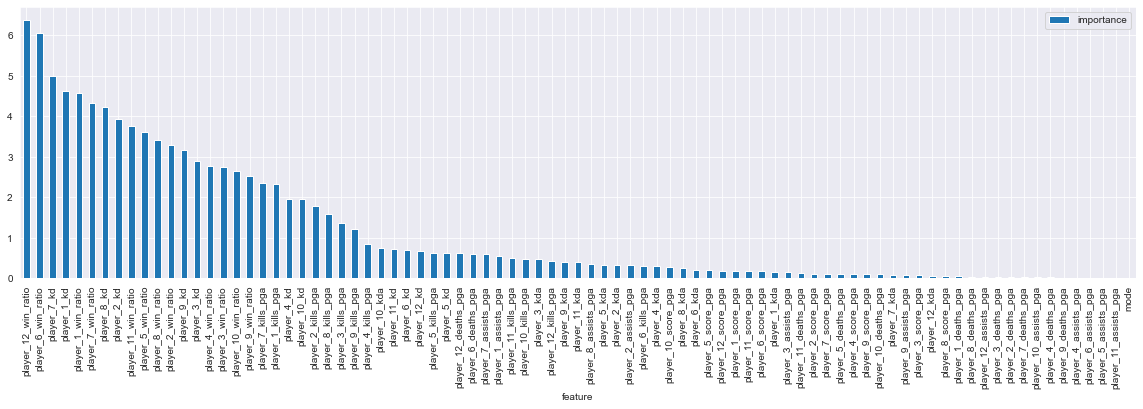

In [19]:
importances.plot(kind="bar", x="feature", y="importance", figsize=(20, 5))

In [ ]:
class CustomCatBoostClassifier(CatBoostClassifier):
    def fit(self, X, y=None, **fit_params):
        return super().fit(
            X,
            y=y,
            cat_features=["mode"],
            **fit_params
            )

pipeline = make_pipeline(CustomCatBoostClassifier(verbose=False, task_type='GPU', random_state=RANDOM_STATE))
acc_scores = cross_val_score(pipeline, X, Y, cv=3, scoring="accuracy", n_jobs=-1)
print(f"Mean acc = {acc_scores.mean()}, Std acc = {acc_scores.std()}")
print(pipeline)

Mean acc = 0.7354318113840592, Std acc = 0.0006893767656310474
Pipeline(steps=[('customcatboostclassifier',
                 <__main__.CustomCatBoostClassifier object at 0x7f974ddf0b20>)])


# Random forest

In [ ]:
pipeline = make_pipeline(RandomForestClassifier())
acc_scores = cross_val_score(pipeline, X, Y, cv=4, scoring="accuracy", n_jobs=-1)
print(f"Mean acc = {acc_scores.mean()}, Std acc = {acc_scores.std()}")
print(pipeline)

Mean acc = 0.7165999548704958, Std acc = 0.0007046547932585566
Pipeline(steps=[('randomforestclassifier', RandomForestClassifier())])


# Deep learning model

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scikeras.wrappers import KerasClassifier
tf.test.gpu_device_name()

'/device:GPU:0'

In [15]:
X_train.drop(columns=["mode"], inplace=True)
X_test.drop(columns=["mode"], inplace=True)

In [18]:
model = keras.Sequential()
model.add(keras.Input(shape=(len(X_train.columns),)))
# model.add(layers.Dense(len(X_train.columns), activation="relu"))
# model.add(layers.Dropout(0.1))
model.add(layers.Dense(12, activation="relu"))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

clf = KerasClassifier(model=model, epochs=25, batch_size=25)

pipeline = make_pipeline(clf)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 12)                1308      
                                                                 
 dropout_2 (Dropout)         (None, 12)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 13        
                                                                 
Total params: 1,321
Trainable params: 1,321
Non-trainable params: 0
_________________________________________________________________


In [19]:
pipeline.fit(X_train, y_train)

Epoch 1/25
8266/8266 [==============================] - 35s 4ms/step - loss: 4.5296 - accuracy: 0.5072
Epoch 2/25
8266/8266 [==============================] - 35s 4ms/step - loss: 0.6934 - accuracy: 0.5002
Epoch 3/25
4901/8266 [================>.............] - ETA: 14s - loss: 0.6932 - accuracy: 0.5017

KeyboardInterrupt: 

In [ ]:
y_pred = pipeline.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print(pipeline)